In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from model_soiling import generate_my_soiling_signals

import pandas as pd
import cvxpy as cvx
from glob import glob
from time import time
from pathlib import Path

from solardatatools import DataHandler
from solardatatools.algorithms import soiling_seperation
from solardatatools.utilities import progress

In [37]:
# SAVE = False

SAVE = True

if SAVE:
    import matplotlib
    sns.set_context('paper')
    matplotlib.rcParams['axes.unicode_minus'] = False
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

In [10]:
np.random.seed(42)
dfs, names = generate_my_soiling_signals()

In [11]:
names

['normal',
 'M Soil, H season',
 'M Soil, H noise',
 'Seasonal cleaning',
 'L/M Soil (.0005)',
 'Low Soil (.0001)']

## Synthetic data example 1

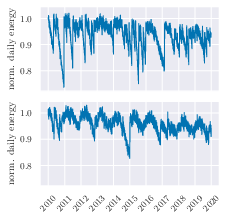

In [92]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(3.25, 3.15))
ax[0].plot(dfs[0].index, dfs[0]['daily_norm'], linewidth=0.8)
ax[1].plot(dfs[0].index, dfs[1]['daily_norm'], linewidth=0.8)
ax[0].set_ylabel('norm. daily energy')
ax[1].set_ylabel('norm. daily energy')
plt.xticks(rotation=45)
plt.tight_layout()
if SAVE:
    fig.savefig('synthetic-soil.pgf')

In [30]:
data = dfs[0]
soiling_signal = data['daily_norm'].values

config = {
    'degradation_term': True, 
    'tau': 0.85, 
    'iterations': 3, 
    'w1': 0.5, 
    'w2': 8e-2,
    'w3': 1e-2,
    'w4': 1e3
}
ti = time()
s1d, s2d, s3d, srd = soiling_seperation(
    soiling_signal, **config
)
result1 = {
    's1': s1d, 's2': s2d, 's3': s3d, 'sr': srd
}
tf = time()
print('this took {:.1f} seconds'.format(tf - ti))

data = dfs[1]
soiling_signal = data['daily_norm'].values

config = {
    'degradation_term': True, 
    'tau': 0.85, 
    'iterations': 3, 
    'w1': 0.5, 
    'w2': 8e-2,
    'w3': 1e-2,
    'w4': 1e3
}
ti = time()
s1d, s2d, s3d, srd = soiling_seperation(
    soiling_signal, **config
)
result2 = {
    's1': s1d, 's2': s2d, 's3': s3d, 'sr': srd
}
tf = time()
print('that took {:.1f} seconds'.format(tf - ti))

that took 19.5 seconds
that took 19.9 seconds


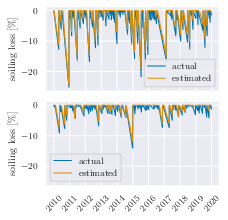

In [91]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(3.25, 3.15))
ax[0].plot(dfs[0].index, (dfs[0].soiling.values - 1) * 100, linewidth=0.8, label='actual')
ax[0].plot(dfs[0].index, result1['s1'] * 100, linewidth=0.8, label='estimated')
ax[1].plot(dfs[1].index, (dfs[1].soiling.values - 1) * 100, linewidth=0.8, label='actual')
ax[1].plot(dfs[1].index, result2['s1'] * 100, linewidth=0.8, label='estimated')
for i in range(2):
    ax[i].set_ylabel('soiling loss [%]')
    ax[i].legend()
plt.xticks(rotation=45)
plt.tight_layout()
if SAVE:
    fig.savefig('synthetic-results.pgf')

## Soiling test data

In [43]:
fn = '/Users/bennetmeyers/Documents/PVInsight/phase_1/algorithms_dev/soiling/total_data/unified_data.csv'
if not Path(fn).is_file():
    files = glob('total_data/total_p*.csv')
    files.sort()
    total_dfs = [pd.read_csv(f, index_col=0, parse_dates=[0]) for f in files]
    df = pd.concat(total_dfs)
    df.to_csv(fn)
else:
    df = pd.read_csv(fn, index_col=0, parse_dates=True)

dh1 = DataHandler(df, aggregate='5min')
dh2 = DataHandler(df, aggregate='5min')

dh1.run_pipeline(power_col=df.columns[1], fix_shifts=False, correct_tz=False)
dh2.run_pipeline(power_col=df.columns[2], fix_shifts=False, correct_tz=False)

e1 = np.sum(dh1.filled_data_matrix, axis=0)
e2 = np.sum(dh2.filled_data_matrix, axis=0)
soiling_PI = e1/e2
soiling_PI[soiling_PI > 1.5] = np.nan

total time: 7.45 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              1.29s
Cleaning                   0.11s
Filtering/Summarizing      6.05s
    Data quality           0.13s
    Clear day detect       0.13s
    Clipping detect        5.26s
    Capacity change detect 0.53s

total time: 7.61 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              2.19s
Cleaning                   0.10s
Filtering/Summarizing      5.31s
    Data quality           0.14s
    Clear day detect       0.13s
    Clipping detect        4.52s
    Capacity change detect 0.52s



/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


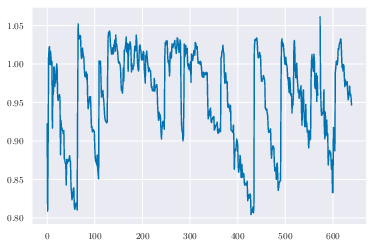

In [44]:
plt.plot(soiling_PI);

In [46]:
soiling_signal = soiling_PI

config = {
    'degradation_term': False, 
    'tau': 0.85, 
    'iterations': 5, 
    'w1': 0.5, 
    'w2': 1e-2,
    'w3': 1e-2,
    'w4': 1e3,
}
# config['soiling_max'] = np.nanquantile(soiling_PI, .98)

s1d, s2d, s3d, srd = soiling_seperation(
    soiling_signal, **config
)

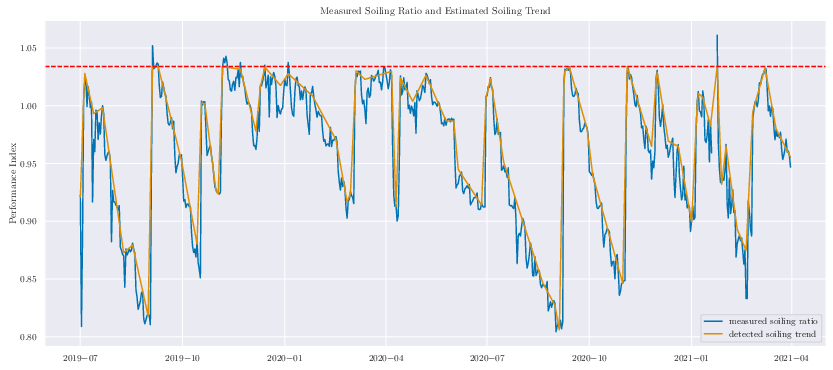

In [47]:
plt.figure(figsize=(14, 6))
xs = dh1.day_index
plt.plot(xs, soiling_PI, label='measured soiling ratio')
plt.plot(xs, s1d+np.nanquantile(soiling_PI, .98), label='detected soiling trend')
plt.ylabel('Performance Index')
plt.title('Measured Soiling Ratio and Estimated Soiling Trend')
shift = np.nanquantile(soiling_PI, .98)
plt.axhline(shift, ls='--', color='red')
plt.legend();

In [48]:
soiling_signal = e1 / np.nanquantile(e1, .95)
config = {
    'degradation_term': True, 
    'tau': 0.85, 
    'iterations': 5, 
    'w1': 1.5, 
    'w2': 2e-2,
    'w3': 1e-1,
    'w4': 5e2
}

s1e, s2e, s3e, sre = soiling_seperation(
    soiling_signal, **config
)

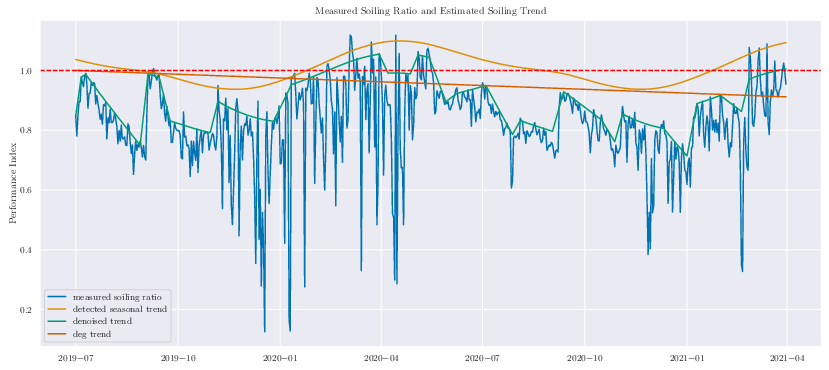

In [49]:
plt.figure(figsize=(14, 6))
xs = dh1.day_index
plt.plot(xs, soiling_signal, label='measured soiling ratio')
plt.plot(xs, s2e, label='detected seasonal trend')
plt.plot(xs, s1e + s2e + s3e, label='denoised trend')
plt.plot(xs, s3e + 1, label='deg trend')
plt.ylabel('Performance Index')
plt.title('Measured Soiling Ratio and Estimated Soiling Trend')
plt.axhline(1, ls='--', color='red')
plt.legend();

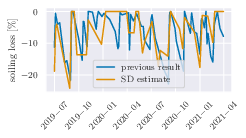

In [89]:
fig = plt.figure(figsize=(3.5,2.0))
plt.plot(xs, s1d*100, label='previous result')
plt.plot(xs, s1e*100, label='SD estimate')
plt.ylabel('soiling loss [%]')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
if SAVE:
    fig.savefig('label-compare.pgf')

In [57]:
np.corrcoef(s1d, s1e)

array([[1.       , 0.6598717],
       [0.6598717, 1.       ]])

In [59]:
from solardatatools.dataio import load_cassandra_data

In [60]:
siteid = "TADBC1078041" # winter shade
df = load_cassandra_data(siteid)

Query of 193051 rows complete in 3.99 seconds


In [61]:
dh = DataHandler(df, convert_to_ts=True)
dh.run_pipeline('ac_power_01', solver='MOSEK')#, end_day_ix=1600)
dh.report()
dh.plot_heatmap(matrix='filled');

total time: 12.81 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              3.28s
Cleaning                   5.36s
Filtering/Summarizing      4.16s
    Data quality           0.26s
    Clear day detect       0.20s
    Clipping detect        2.72s
    Capacity change detect 0.98s

Length:                3.57 years
Capacity estimate:     3.23 kW
Data sampling:         5 minute
Data quality score:    92.8%
Data clearness score:  45.2%
Inverter clipping:     False
Time shifts corrected: False
Time zone correction:  None


In [63]:
from solardatatools.algorithms import SoilingAnalysis

In [64]:
soiling = SoilingAnalysis(dh)
soiling.run()

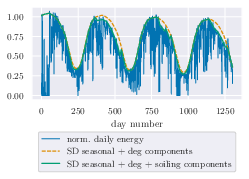

In [90]:
fig = plt.figure(figsize=(3.5,2.65))
plt.plot(soiling.soiling_signal, label='norm. daily energy', linewidth=0.75)
plt.plot(soiling.seasonal_component + soiling.degradation_component, label='SD seasonal + deg components', 
        linewidth=1, ls='--')
plt.plot(soiling.seasonal_component + soiling.degradation_component +
         soiling.soiling_component, label='SD seasonal + deg + soiling components',
        linewidth=1)
plt.xlabel('day number')
fig.subplots_adjust(bottom=0.3, wspace=0.33)
plt.gca().legend(loc='upper center', 
             bbox_to_anchor=(0.5, -0.3))
plt.tight_layout()
if SAVE:
    fig.savefig('soil-decomp.pgf')

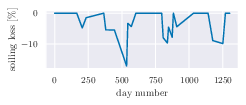

In [88]:
fig = plt.figure(figsize=(3.5,1.5))
plt.plot(soiling.soiling_component*100)
plt.xlabel('day number')
plt.ylabel('soiling loss [%]')
plt.tight_layout()
if SAVE:
    fig.savefig('soil-isolate.pgf')

## Comparison of degradation term estimate to SCSF

In [44]:
dh1.fit_statistical_clear_sky_model()

----------------------
SCSF Problem Setup
----------------------
Matrix Size: 288 x 640 = 184320 power measurements
Sparsity: 69.99%
55313 non-zero measurements under clear conditions
Model size: 288 x 6 + 6 x 640 = 5568 parameters


----------------------
Algorithm Iterations
----------------------
Starting at Objective: 9.688e+07, f1: 5.206e+05, f2: 2.580e+02, f3: 7.976e+07, f4: 1.660e+07
    Minimizing left matrix


/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


    Minimizing right matrix
1 - Objective: 7.524e+05, f1: 6.877e+05, f2: 2.272e+02, f3: 6.446e+04, f4: 2.561e-06
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
2 - Objective: 7.081e+05, f1: 6.425e+05, f2: 4.416e+02, f3: 6.512e+04, f4: 1.301e-07
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
3 - Objective: 7.052e+05, f1: 6.399e+05, f2: 4.464e+02, f3: 6.485e+04, f4: 1.689e-07
Caution: residuals increased
    Minimizing left matrix
    Minimizing right matrix
4 - Objective: 7.046e+05, f1: 6.394e+05, f2: 4.665e+02, f3: 6.467e+04, f4: 2.268e-06
Caution: residuals increased
Minimization complete in 1.41 minutes


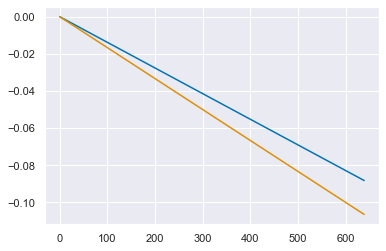

In [45]:
plt.plot(s3e)
plt.plot(dh1.scsf.beta_value * np.linspace(0, len(s3e) / 365, len(s3e)))